In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
word_embedding <class 'numpy.ndarray'> (1004, 304) float64
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


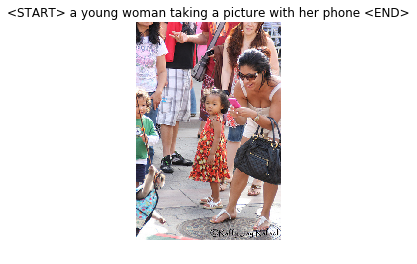

In [6]:
show_image(1)

In [7]:
def sparse_to_one_hot(sparse_input, max_dim):
    one_hot = np.zeros((sparse_input.shape[0], max_dim))
    for idx, input_index in enumerate(sparse_input):
        one_hot[idx, input_index] = 1
    return one_hot

def captions_to_one_hot(captions, vocab_dim):
    return [sparse_to_one_hot(sentence, vocab_dim) for sentence in captions]

def verify_caption_train_target_offset(train_caption, target_caption):
    for i in range(len(target_caption) - 1):
        assert train_caption[i + 1] == target_caption[i]
        
def get_train_target_caption(train_captions_as_word_ids, null_representation):
    """
        Convert training data:
        '<START> a variety of fruits and vegetables sitting on a kitchen counter'
        to target:
        'a variety of fruits and vegetables sitting on a kitchen counter <END>'
    """
    target_captions_as_word_ids = train_captions_as_word_ids[:, 1:]
    train_captions_as_word_ids = train_captions_as_word_ids[:, :-1]
    verify_caption_train_target_offset(train_captions_as_word_ids[0], target_captions_as_word_ids[0])
    not_null_target_mask = target_captions_as_word_ids != null_representation
    return train_captions_as_word_ids, target_captions_as_word_ids, not_null_target_mask


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [9]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

Vocab Dim: 1004
Image Feature Dim: 4096
Word Embedding Dim: 304


## Model Architecture

In [1]:
# Word Input
sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)

if enable_preprocessed_embedding:
    embedding_init = tf.constant(data['word_embedding'], dtype=tf.float32)
    embedding = tf.get_variable("embedding", initializer=embedding_init)
else:
    embedding_init = tf.random_normal_initializer()
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32, initializer=embedding_init)

word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, hidden_dim, 'image_proj')
initial_cell_state = image_projection * 0

# LSTM states
sy_hidden_state = tf.placeholder(shape=[None, hidden_dim], name="hidden_lstm_state", dtype=tf.float32)
sy_cell_state = tf.placeholder(shape=[None, hidden_dim], name="cell_lstm_state", dtype=tf.float32)

sy_is_initial_step = tf.placeholder(tf.int32, shape=[], name="is_initial_step")

initial_lstm_state = tf.cond(sy_is_initial_step > 0, 
                             lambda: tf.nn.rnn_cell.LSTMStateTuple(image_projection * 0, image_projection), 
                             lambda: tf.nn.rnn_cell.LSTMStateTuple(sy_cell_state, sy_hidden_state))

NameError: name 'tf' is not defined

In [11]:
# LSTM
cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
output_hidden_state, output_cell_state = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)
hidden_to_word = layer_utils.affine_transform(output_hidden_state, vocab_dim, 'hidden_to_word')

# Process entropy from logits and one-hot target
sy_caption_target = tf.placeholder(shape=[None, None], name="caption_target", dtype=tf.int64)
target_one_hot = tf.one_hot(sy_caption_target, vocab_dim, dtype=tf.int64)
raw_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=target_one_hot, logits=hidden_to_word)

# Apply not-null mask to ignore cross-entropy on trailing padding
sy_target_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
mask_not_null = tf.cast(sy_target_mask, dtype=tf.float32)
masked_cross_entropy = raw_cross_entropy * mask_not_null

# Get average cross entropy over caption 
cross_entropy = tf.reduce_mean(tf.reduce_sum(masked_cross_entropy, axis=1))
update_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction accuracy
total_predictions = tf.cast(tf.reduce_sum(mask_not_null), tf.float32)
prediction = tf.argmax(hidden_to_word, axis = 2)
correct_pred = tf.equal(prediction, sy_caption_target)
accuracy = tf.reduce_sum(tf.cast(correct_pred, tf.float32)) / total_predictions

print(output_hidden_state)
print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
print("hidden lstm: ", hidden_to_word)

print("\n-- Loss tensors --")
print("Target one hot: ", target_one_hot)
print("Mask not null: ", mask_not_null)
print("Raw cross entropy: ", raw_cross_entropy)
print("Masked cross entropy: ", cross_entropy)
print("Cross entropy: ", cross_entropy)

print("\n-- Prediction tensors --")
print("target given: ", sy_caption_target)
print("correct_pred prediction shape:", accuracy)


Tensor("rnn/transpose:0", shape=(?, ?, 512), dtype=float32)
-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 304), dtype=float32)
hidden lstm:  Tensor("hidden_to_word/dense/BiasAdd:0", shape=(?, ?, 1004), dtype=float32)

-- Loss tensors --
Target one hot:  Tensor("one_hot:0", shape=(?, ?, 1004), dtype=int64)
Mask not null:  Tensor("Cast_1:0", shape=(?, ?), dtype=float32)
Raw cross entropy:  Tensor("Reshape_2:0", shape=(?, ?), dtype=float32)
Masked cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)
Cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)

-- Prediction tensors --
target given:  Tensor("caption_target:0", shape=(?, ?), dtype=int64)
correct_pred prediction shape: Tensor("truediv:0", shape=(), dtype=float32)


## Training

In [13]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [14]:
iter_num = 200
batch_size = 100
embeddings = []
dummy_hidden_state = np.zeros((batch_size, hidden_dim))
dummy_cell_state = np.zeros((batch_size, hidden_dim))
is_training = True
for i in range(iter_num):
    mini_batch, features, url = sample_coco_minibatch(data,  batch_size=batch_size, split='train')
    train_captions, target_captions, target_mask = get_train_target_caption(mini_batch, NULL_ID)
    _, c, a = sess.run([update_op, cross_entropy, accuracy], feed_dict=
                       {sy_image_feat_input: features,
                        sy_caption_input: train_captions, 
                        sy_caption_target: target_captions,
                        sy_target_mask: target_mask,
                        sy_is_initial_step: is_training,
                        sy_hidden_state: dummy_hidden_state,
                        sy_cell_state: dummy_cell_state
                       })
    if (i % 10 == 0):
        print("iter {}, cross-entropy: {}, accuracy: {}".format(i, c, a))

iter 0, cross-entropy: 76.0421142578125, accuracy: 0.001818181830458343
iter 10, cross-entropy: 53.291282653808594, accuracy: 0.19646017253398895
iter 20, cross-entropy: 48.300941467285156, accuracy: 0.23762376606464386
iter 30, cross-entropy: 48.279640197753906, accuracy: 0.26296958327293396
iter 40, cross-entropy: 46.490142822265625, accuracy: 0.305799663066864
iter 50, cross-entropy: 47.990230560302734, accuracy: 0.2969283163547516
iter 60, cross-entropy: 42.8662223815918, accuracy: 0.32278481125831604
iter 70, cross-entropy: 45.2893180847168, accuracy: 0.3286835253238678
iter 80, cross-entropy: 41.25941467285156, accuracy: 0.35008975863456726
iter 90, cross-entropy: 43.5084114074707, accuracy: 0.3333333432674408
iter 100, cross-entropy: 40.84452819824219, accuracy: 0.34178322553634644
iter 110, cross-entropy: 39.9460334777832, accuracy: 0.3282511234283447
iter 120, cross-entropy: 38.385337829589844, accuracy: 0.3354838788509369
iter 130, cross-entropy: 38.40262222290039, accuracy: 

#### Initializing affine transform weights around zero
Cross entropy reached 46 within 100 iterations when conditioning on image as hidden state (cell state zero).

Cross entroy reached 23 and accuracy 0.49, by 2000 iterations with the same set up.


Cross entropy reached 50 within 100 iterations without conditioning on image.

Model mostly learn to start with a, and END


#### Initialize affine transform with random weights at mean 0, std = 1.0
Cross entropy started off really high 300, reaching 156, but words are more diversed


#### Initialize words with glove embedding, conditioning on image hidden state
Cross entropy reached 43 within 100 iterations when conditioning on image as hidden state (cell state zero).


## Prediction

In [15]:
def predict_output(session, caption, image_feature):
    hidden_state = np.zeros((1, hidden_dim))
    cell_state = np.zeros((1, hidden_dim))
    pred = session.run(prediction,feed_dict =
                       {sy_caption_input: caption,
                        sy_image_feat_input: image_feature,
                        sy_is_initial_step: True,
                        sy_hidden_state: hidden_state,
                        sy_cell_state: cell_state
                       })
    return pred

def sample_caption(session, image_feature, start_token_id, end_token_id):
    
    # For first iteration, to take process initial state from image feature 
    # Then, we feed back initial states in subsequent iterations
    is_initial_step = True
    input_hidden_state = np.zeros((1, hidden_dim))
    input_cell_state = np.zeros((1, hidden_dim))
        
    sampled_words = []
    current_input = [[start_token_id]]
    for i in range(15):
        p, c, h = sess.run([prediction, output_cell_state, output_hidden_state], feed_dict=
                           {sy_image_feat_input: [image_feature],
                            sy_caption_input: current_input, 
                            sy_is_initial_step: is_initial_step,
                            sy_hidden_state: input_hidden_state,
                            sy_cell_state: input_cell_state}
                          )
        
        # Update hidden/cell states
        input_cell_state = c[0]
        input_hidden_state = h[0]
        current_input = p
        is_initial_step = False
        
        sampled_words.append(p[0][0])

    return np.array(sampled_words)

def decode_caption_with(word_id_sequence, key_name = 'idx_to_word'):
    id_to_word = data[key_name]
    return decode_captions(word_id_sequence, id_to_word)


In [35]:
random_sample_index = np.random.randint(batch_size)
prediction_on_caption_input = decode_caption_with(predict_output(sess, [train_captions[random_sample_index]], [features[random_sample_index]])[0])
ground_truth = decode_caption_with(target_captions [random_sample_index])
prediction_on_previous_predicted = decode_caption_with(sample_caption(sess, features[random_sample_index], START_ID, END_ID))

print("GT     : ", ground_truth)
print("Train  : ", prediction_on_caption_input)
print("Sample : ", prediction_on_previous_predicted)

GT     :  a table filled with plates of food and glasses of beer <END>
Train  :  a man with with a of a <END>
Sample :  a man in a <UNK> <UNK> on a <UNK> <END>
